#Author: Md Mintu Miah, PhD; Post Doctoral Researcher at PATH, UC Berkeley
#Project: Contract 65A0911: Complete Cities: Bicycle Network Connectivity Evaluation Methodology
#PI: Alex Skabardonis, PhD, Professor, UC Berkeley

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
from collections.abc import Mapping
from distutils.version import LooseVersion
from pybna import Importer
import geopandas as gpd
import pybna

In [71]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import numpy as np
import math
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point
import io

In [8]:
%%time
# Import Configuration file
i = pybna.Importer(config="config.yaml")
# Import Study Area boundary shape file
i.import_boundary('City of Sacramento_Boundary.shp', overwrite=True)
# Mention the State fips, for California it is 6
i.import_census_blocks(fips=6, overwrite=True)
i.import_census_jobs("received.neighborhood_census_block_jobs",state="CA", overwrite=True)

Connecting to database
Copying boundary to database
Loading boundary
Loading data from http://www2.census.gov/geo/tiger/TIGER2010BLKPOPHU/tabblock2010_06_pophu.zip
Filtering blocks to boundary
Filtering out water
Copying blocks to database
Loading data for state CA
No data for state CA for year 2020. Checking previous year.
Copying jobs to database
CPU times: total: 1min 34s
Wall time: 11min 54s


In [9]:
%%time
i.import_osm_network(overwrite=True)

Copying OSM ways to database
Copying OSM intersections to database
Processing OSM data in database
CPU times: total: 3min 17s
Wall time: 4min 15s


In [10]:
%%time
# stress
s = pybna.Stress(config='config.yaml')
s.segment_stress()
s.crossing_stress()

Connecting to database
Calculating stress on shared streets
Calculating stress on streets with bike lanes
Calculating stress on streets with cycle tracks
Calculating stress on paths
Calculating stress on shared streets
Calculating stress on streets with bike lanes
Calculating stress on streets with cycle tracks
Calculating stress on paths
  ....forward
  ....backward
CPU times: total: 406 ms
Wall time: 24.6 s


In [72]:
# Read the LTS shape file
lts=gpd.read_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/neighborhood_ways.shp")
lts = lts.rename(columns={'OSMID':'osmid'})
lts=lts.rename({'INTERSECTI':'u', 'INTERSE_01':'v'}, axis='columns')
lts['length']=lts.length
lts.head()

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length
0,21113,"{981539920,981539918,981539919}",secondary,None,ft,40884,40569,NaN,NaN,None,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (139267.831 99099.111, 139232.287 9...",114.734569
1,38818,{442356976},secondary,None,ft,4488,4485,NaN,NaN,None,...,None,?,?,4.0,NaN,NaN,NaN,None,"LINESTRING (126547.244 116173.957, 126546.974 ...",13.322725
2,40960,"{617694798,617694801,1025104341,1025104342,102...",secondary,None,ft,9751,9739,NaN,NaN,lane,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (128014.726 124945.470, 128153.759 ...",452.265878
3,50808,{617563730},primary,None,ft,34105,34106,NaN,NaN,None,...,None,?,?,4.0,NaN,NaN,NaN,None,"LINESTRING (136289.175 107312.461, 136272.973 ...",16.202618
4,54239,"{1025089940,617500413,1025089941,1019984317}",secondary,None,ft,7292,8709,NaN,NaN,None,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (130553.758 122728.366, 130528.530 ...",272.883211


# Lets calculate the slope for each link

In [73]:
#https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
import rasterio
from rasterio.plot import show
from rasterio import plot as rioplot
import matplotlib.pyplot as plt

EPSG:4269


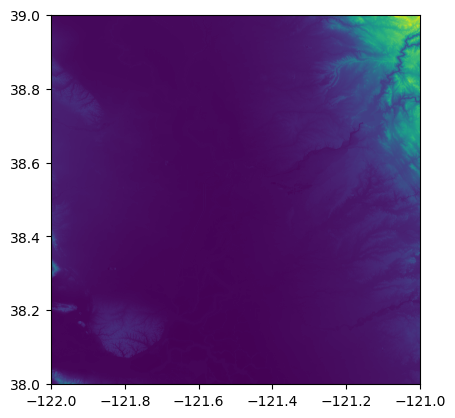

<AxesSubplot: >

In [74]:
# Open the raster image
barea_slope = rasterio.open('H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/Slope/USGS_13_n39w122_20220206.tif')
print(barea_slope.crs)
rioplot.show(barea_slope)

In [75]:
# only band is elev value (in m)
band1 = barea_slope.read(1, masked=True)  # mask noData cells [shouldn't be necessary on land]
stats = {'min': band1.min(), 'mean': band1.mean(), 'max': band1.max()}
print(stats)

{'min': -7.3393726, 'mean': 42.889994523835824, 'max': 681.56647}


In [76]:
# Reproject the geometries by replacing the values with projected ones
lts_new = lts.to_crs(epsg=4326)
lts_new.head(10)

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length
0,21113,"{981539920,981539918,981539919}",secondary,None,ft,40884,40569,NaN,NaN,None,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (-121.40489 38.42191, -121.40530 38...",114.734569
1,38818,{442356976},secondary,None,ft,4488,4485,NaN,NaN,None,...,None,?,?,4.0,NaN,NaN,NaN,None,"LINESTRING (-121.54862 38.57692, -121.54862 38...",13.322725
2,40960,"{617694798,617694801,1025104341,1025104342,102...",secondary,None,ft,9751,9739,NaN,NaN,lane,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (-121.53078 38.65580, -121.52918 38...",452.265878
3,50808,{617563730},primary,None,ft,34105,34106,NaN,NaN,None,...,None,?,?,4.0,NaN,NaN,NaN,None,"LINESTRING (-121.43796 38.49619, -121.43815 38...",16.202618
4,54239,"{1025089940,617500413,1025089941,1019984317}",secondary,None,ft,7292,8709,NaN,NaN,None,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (-121.50187 38.63560, -121.50216 38...",272.883211
5,54241,"{1033721769,1033721770,1033721772}",secondary,None,ft,8908,8907,NaN,NaN,None,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (-121.51080 38.65110, -121.51096 38...",75.755043
6,54263,{1029988642},secondary,None,ft,8647,8644,NaN,NaN,None,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (-121.50879 38.64404, -121.50879 38...",14.423239
7,102786,"{1029988642,617500412}",secondary,None,ft,8650,8647,NaN,NaN,None,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (-121.50804 38.64063, -121.50809 38...",388.316012
8,106454,{983123368},secondary,None,ft,8711,8714,NaN,NaN,None,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (-121.50421 38.63760, -121.50406 38...",16.070700
9,222,"{617694840,967809586}",secondary,None,ft,7290,7289,NaN,NaN,None,...,None,?,?,4.0,NaN,NaN,NaN,None,"LINESTRING (-121.50275 38.63640, -121.50218 38...",170.525647


In [77]:
# get the slope for each link of the network
%time
lts_new
# First identify the starting and ending node of each link
lts_new['starting point'] = None
lts_new['ending point'] = None

for index, row in lts_new.iterrows():
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    lts_new.at[index,'starting point'] = Point(first_coord)
    lts_new.at[index,'ending point'] = Point(last_coord)
    lts_new

CPU times: total: 0 ns
Wall time: 0 ns


<AxesSubplot: >

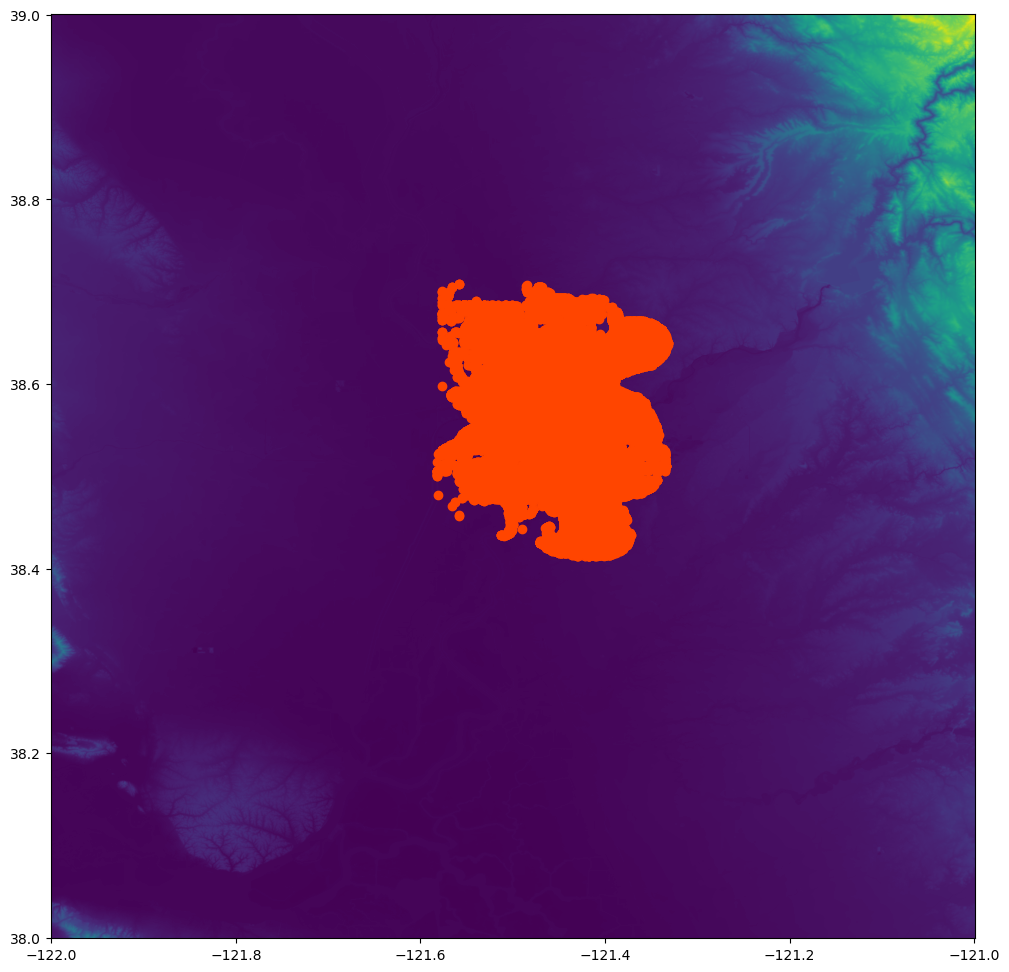

In [78]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(12,12))
lts_new.boundary.plot(ax=ax, color='orangered')
show(barea_slope, ax=ax)

In [79]:
# Calculate each link starting lat and long
sf1=lts_new.loc[:,["ROAD_ID","starting point"]]
sf1.columns=["ROAD_ID","geometry"]
sf1['start_lon'] = sf1.geometry.apply(lambda p: p.x)
sf1['start_lat'] = sf1.geometry.apply(lambda p: p.y)
sf2=sf1.loc[:,["ROAD_ID","geometry","start_lon","start_lat"]]
sf2.head(5)

,ROAD_ID,geometry,start_lon,start_lat
0,21113,POINT (-121.4048917 38.4219148),-121.404892,38.421915
1,38818,POINT (-121.54862240000001 38.5769223),-121.548622,38.576922
2,40960,POINT (-121.5307763 38.6557975),-121.530776,38.655797
3,50808,POINT (-121.43796209999998 38.49619259999999),-121.437962,38.496193
4,54239,POINT (-121.5018743 38.63559519999999),-121.501874,38.635595


In [80]:
# Calculate each link starting elevation
sf2["starting_ele"]= None
#point in test['geometry']:
x = sf2["start_lon"]
y = sf2["start_lat"]
row, col = barea_slope.index(x,y)
sf2["starting_ele"]=barea_slope.read(1)[row,col]

In [81]:
%%time
# Calculate each link end point elevation
ef1=lts_new.loc[:,["ROAD_ID","ending point"]]
ef1.columns=["ROAD_ID","geometry"]
ef1['end_lon'] = ef1.geometry.apply(lambda p: p.x)
ef1['end_lat'] = ef1.geometry.apply(lambda p: p.y)
ef2=ef1.loc[:,["ROAD_ID","geometry","end_lon","end_lat"]]
ef2.head(5)

CPU times: total: 766 ms
Wall time: 759 ms


,ROAD_ID,geometry,end_lon,end_lat
0,21113,POINT (-121.4062016 38.421848),-121.406202,38.421848
1,38818,POINT (-121.548624 38.5770423),-121.548624,38.577042
2,40960,POINT (-121.5255811 38.655793800000005),-121.525581,38.655794
3,50808,POINT (-121.43814779999998 38.4961942),-121.438148,38.496194
4,54239,POINT (-121.5037107 38.6375759),-121.503711,38.637576


In [83]:
%%time
# Calculate the each link end elevation
ef2["ending_ele"]= None
#point in test['geometry']:
x = ef2["end_lon"]
y = ef2["end_lat"]
row, col = barea_slope.index(x,y)
ef2["ending_ele"]=barea_slope.read(1)[row,col]

CPU times: total: 422 ms
Wall time: 419 ms


In [84]:
%%time
# Calculate the slope for each link
from functools import reduce
barea_all=[sf2,ef2,lts_new]

barea_all1= reduce(lambda  left,right: pd.merge(left,right,on=['ROAD_ID'],
                                            how='outer'), barea_all).fillna('0')
barea_all1["slope"]=abs((barea_all1['starting_ele']-barea_all1['ending_ele'])/barea_all1['length'])*100
barea_all1=barea_all1.drop_duplicates(subset=['ROAD_ID'], keep='first')
barea_all1.head()

CPU times: total: 406 ms
Wall time: 407 ms


,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope
0,21113,POINT (-121.4048917 38.4219148),-121.404892,38.421915,10.225750,POINT (-121.4062016 38.421848),-121.406202,38.421848,9.972596,"{981539920,981539918,981539919}",...,0,0,0,0,0,"LINESTRING (-121.40489 38.42191, -121.40530 38...",114.734569,POINT (-121.4048917 38.4219148),POINT (-121.4062016 38.421848),0.220643
1,38818,POINT (-121.54862240000001 38.5769223),-121.548622,38.576922,6.259382,POINT (-121.548624 38.5770423),-121.548624,38.577042,5.916164,{442356976},...,4.0,0,0,0,0,"LINESTRING (-121.54862 38.57692, -121.54862 38...",13.322725,POINT (-121.54862240000001 38.5769223),POINT (-121.548624 38.5770423),2.576183
2,40960,POINT (-121.5307763 38.6557975),-121.530776,38.655797,7.503405,POINT (-121.5255811 38.655793800000005),-121.525581,38.655794,7.260961,"{617694798,617694801,1025104341,1025104342,102...",...,0,0,0,0,0,"LINESTRING (-121.53078 38.65580, -121.52918 38...",452.265878,POINT (-121.5307763 38.6557975),POINT (-121.5255811 38.655793800000005),0.053607
3,50808,POINT (-121.43796209999998 38.49619259999999),-121.437962,38.496193,8.736792,POINT (-121.43814779999998 38.4961942),-121.438148,38.496194,8.706430,{617563730},...,4.0,0,0,0,0,"LINESTRING (-121.43796 38.49619, -121.43815 38...",16.202618,POINT (-121.43796209999998 38.49619259999999),POINT (-121.43814779999998 38.4961942),0.187384
4,54239,POINT (-121.5018743 38.63559519999999),-121.501874,38.635595,5.963587,POINT (-121.5037107 38.6375759),-121.503711,38.637576,4.145176,"{1025089940,617500413,1025089941,1019984317}",...,0,0,0,0,0,"LINESTRING (-121.50187 38.63560, -121.50216 38...",272.883211,POINT (-121.5018743 38.63559519999999),POINT (-121.5037107 38.6375759),0.666369


<AxesSubplot: >

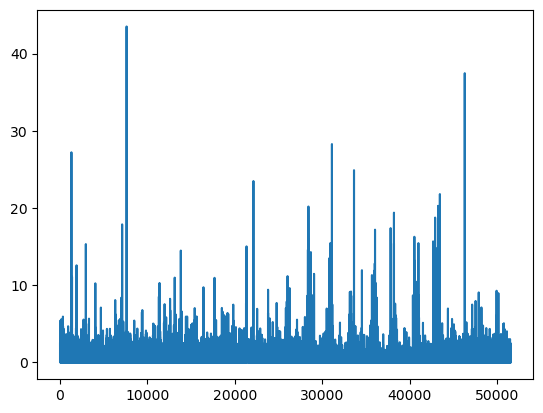

In [85]:
barea_all1.slope.plot()

In [86]:
# write a slope impedance function
def slope_correction(length,FT_SEG_STR,slope):
    if slope <=2:
        return length*(1+FT_SEG_STR)
    elif ((slope>2) and (slope<=4)):
        return length*(1+0.37+FT_SEG_STR)
    elif ((slope>4) and (slope<=6)):
        return length*(1+1.20+FT_SEG_STR)
    else:
        return length*(1+3.20+FT_SEG_STR)

In [87]:
#barea_all1['FT_SEG_STR'].astype(str).astype(int)
barea_all1['FT_SEG_STR']=pd.to_numeric(barea_all1['FT_SEG_STR']).astype(int)
barea_all1['FT_SEG_STR'].dtypes

dtype('int32')

In [88]:
barea_all1['impedance_of_link']=barea_all1.apply(lambda row: slope_correction(row['length'],row['FT_SEG_STR'],row['slope']),axis=1)
barea_all1.head(8)

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
0,21113,POINT (-121.4048917 38.4219148),-121.404892,38.421915,10.225750,POINT (-121.4062016 38.421848),-121.406202,38.421848,9.972596,"{981539920,981539918,981539919}",...,0,0,0,0,"LINESTRING (-121.40489 38.42191, -121.40530 38...",114.734569,POINT (-121.4048917 38.4219148),POINT (-121.4062016 38.421848),0.220643,114.734569
1,38818,POINT (-121.54862240000001 38.5769223),-121.548622,38.576922,6.259382,POINT (-121.548624 38.5770423),-121.548624,38.577042,5.916164,{442356976},...,0,0,0,0,"LINESTRING (-121.54862 38.57692, -121.54862 38...",13.322725,POINT (-121.54862240000001 38.5769223),POINT (-121.548624 38.5770423),2.576183,71.543035
2,40960,POINT (-121.5307763 38.6557975),-121.530776,38.655797,7.503405,POINT (-121.5255811 38.655793800000005),-121.525581,38.655794,7.260961,"{617694798,617694801,1025104341,1025104342,102...",...,0,0,0,0,"LINESTRING (-121.53078 38.65580, -121.52918 38...",452.265878,POINT (-121.5307763 38.6557975),POINT (-121.5255811 38.655793800000005),0.053607,452.265878
3,50808,POINT (-121.43796209999998 38.49619259999999),-121.437962,38.496193,8.736792,POINT (-121.43814779999998 38.4961942),-121.438148,38.496194,8.706430,{617563730},...,0,0,0,0,"LINESTRING (-121.43796 38.49619, -121.43815 38...",16.202618,POINT (-121.43796209999998 38.49619259999999),POINT (-121.43814779999998 38.4961942),0.187384,81.013092
4,54239,POINT (-121.5018743 38.63559519999999),-121.501874,38.635595,5.963587,POINT (-121.5037107 38.6375759),-121.503711,38.637576,4.145176,"{1025089940,617500413,1025089941,1019984317}",...,0,0,0,0,"LINESTRING (-121.50187 38.63560, -121.50216 38...",272.883211,POINT (-121.5018743 38.63559519999999),POINT (-121.5037107 38.6375759),0.666369,272.883211
5,54241,POINT (-121.51080310000002 38.6511049),-121.510803,38.651105,3.426614,POINT (-121.51126579999999 38.651681399999994),-121.511266,38.651681,3.999581,"{1033721769,1033721770,1033721772}",...,0,0,0,0,"LINESTRING (-121.51080 38.65110, -121.51096 38...",75.755043,POINT (-121.51080310000002 38.6511049),POINT (-121.51126579999999 38.651681399999994),0.756341,75.755043
6,54263,POINT (-121.50878549999999 38.64403810000001),-121.508785,38.644038,3.288395,POINT (-121.50878820000001 38.64416800000001),-121.508788,38.644168,3.269476,{1029988642},...,0,0,0,0,"LINESTRING (-121.50879 38.64404, -121.50879 38...",14.423239,POINT (-121.50878549999999 38.64403810000001),POINT (-121.50878820000001 38.64416800000001),0.131165,14.423239
7,102786,POINT (-121.5080397 38.6406252),-121.508040,38.640625,3.482120,POINT (-121.50878549999999 38.64403810000001),-121.508785,38.644038,3.288395,"{1029988642,617500412}",...,0,0,0,0,"LINESTRING (-121.50804 38.64063, -121.50809 38...",388.316012,POINT (-121.5080397 38.6406252),POINT (-121.50878549999999 38.64403810000001),0.049889,388.316012


### Lets Calculate the Connectivity

## Helper Function

In [89]:
def node_level_connectivity_score (sf_motor_network,sf_bike_network):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=39590, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_sheortst_path_motor_length=pd.DataFrame.from_dict(motor_length)
    # Calculate the total motor path
    sf_sheortst_path_motor_length['total_motor_path']=sf_sheortst_path_motor_length.sum(numeric_only=True, axis=0)
    sf_sheortst_path_motor_length1=sf_sheortst_path_motor_length[['total_motor_path']]
    # make total motor path as dictonary
    ms_outcomes=sf_sheortst_path_motor_length1.T.to_dict('list')
    # add motor path attribute with grpah nodes
    nx.set_node_attributes(sf_lts_motor_g1, values=ms_outcomes, name="total_motor_path")
    nodes_motor, edges_motor = momepy.nx_to_gdf(sf_lts_motor_g1)
    nodes_motor['total_motor_path'] = nodes_motor['total_motor_path'].str[0]
    
    
    # do it for bike Path
    sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)
    sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=39590, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
    # Calculate the total bike path
    sf_shortest_path_bike_length['total_bike_path']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_bike_length1=sf_shortest_path_bike_length[['total_bike_path']]
    # make total motor path as dictonary
    bs_outcomes=sf_shortest_path_bike_length1.T.to_dict('list')
    # add motor path attribute with grpah nodes
    nx.set_node_attributes(sf_lts_bike_g1, values=bs_outcomes, name="total_bike_path")
    nodes_bike, edges_bike = momepy.nx_to_gdf(sf_lts_bike_g1)
    nodes_bike['total_bike_path'] = nodes_bike['total_bike_path'].str[0]

    #connectivity score
    shortest_path=pd.merge(nodes_motor,nodes_bike,on=['geometry'],how='outer')
    shortest_path1=shortest_path.fillna(0)
    shortest_path1['CS']= shortest_path1['total_bike_path']/shortest_path1['total_motor_path']
    shortest_path1= shortest_path1.replace(np.inf, 999)
    return shortest_path1 


In [90]:
def count_census_block(Connectivity_score):
    if Connectivity_score>=1:
        return 'excellently connected'
    elif (Connectivity_score>=0.90 and Connectivity_score<1.0):
        return 'very well connected  '
    elif (Connectivity_score>=0.60 and Connectivity_score<0.90):
        return 'well connected'
    elif (Connectivity_score>=0.30 and Connectivity_score<0.60):
        return 'fairly connected'
    else:
        return 'poorly connected'

In [91]:
def census_node_level_connectivity_score (sf_connectivity,input_census_tract):
    census_score=gpd.sjoin(sf_connectivity,input_census_tract)
    census_score1=pd.DataFrame({'Meadian CS':census_score.groupby(['GISJOIN'])['CS'].median()}).reset_index()
    census_score2=pd.merge(census_score1,input_census_tract, on=['GISJOIN'], how='inner' )
    return census_score2 

## Connectivity

In [92]:
# Bring US Census track
census_track=gpd.read_file('H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/US_tract_2020.shp')
census_track1=census_track.to_crs(epsg=7131)
census_track1.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0100010020100,01,001,020100,01001020100,201,Census Tract 201,G5020,S,9825304.0,28435.0,+32.4819731,-086.4915648,16217.763443,9.853735e+06,"POLYGON ((3516926.098 77059.002, 3516963.104 7..."
1,G0100010020200,01,001,020200,01001020200,202,Census Tract 202,G5020,S,3320818.0,5669.0,+32.4757580,-086.4724678,9824.372415,3.326483e+06,"POLYGON ((3519482.809 73938.168, 3519490.446 7..."
2,G0100010020300,01,001,020300,01001020300,203,Census Tract 203,G5020,S,5349271.0,9054.0,+32.4740243,-086.4597033,10519.641206,5.358327e+06,"POLYGON ((3521117.478 74718.075, 3521099.105 7..."
3,G0100010020400,01,001,020400,01001020400,204,Census Tract 204,G5020,S,6384282.0,8408.0,+32.4710304,-086.4448353,12521.196228,6.392683e+06,"POLYGON ((3521674.809 77662.170, 3521681.008 7..."
4,G0100010020501,01,001,020501,01001020501,205.01,Census Tract 205.01,G5020,S,6203654.0,0.0,+32.4478607,-086.4225578,11422.446991,6.203654e+06,"POLYGON ((3525078.936 76191.813, 3525244.092 7..."


In [93]:
# read the Davis boundary shape file
study_bd=gpd.read_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/City of Sacramento_Boundary.shp")
study_bd

,OBJECTID,DISTRICT,CITY_NAME,ID,SHAPE_Leng,SHAPE_Area,geometry
0,8,CITY OF SACRAMENTO,SACRAMENTO,6,507620.447535,2.805403e+09,"POLYGON ((6697014.000 2011810.875, 6697823.000..."


<AxesSubplot: >

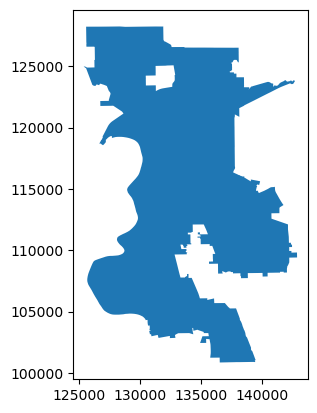

In [94]:
sf_bd_proj = study_bd.to_crs(epsg=7131)
sf_bd_proj.plot()

In [95]:
census_track2=gpd.clip(census_track1,sf_bd_proj)
census_track2.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
10029,G0600670009900,06,067,009900,06067009900,99,Census Tract 99,G5020,S,253729261.0,13027176.0,+38.2710059,-121.5387474,108022.727260,2.667565e+08,"POLYGON ((130651.623 104034.644, 130883.085 10..."
10013,G0600670009639,06,067,009639,06067009639,96.39,Census Tract 96.39,G5020,S,2849240.0,0.0,+38.4298959,-121.4080981,6670.261048,2.849242e+06,"POLYGON ((138916.872 100884.311, 139038.727 10..."
10003,G0600670009614,06,067,009614,06067009614,96.14,Census Tract 96.14,G5020,S,2252500.0,0.0,+38.4372640,-121.4319342,7842.083575,2.252500e+06,"MULTIPOLYGON (((137562.222 101121.474, 137593...."
10006,G0600670009618,06,067,009618,06067009618,96.18,Census Tract 96.18,G5020,S,15198729.0,219134.0,+38.4423863,-121.4660270,18407.208305,1.541786e+07,"MULTIPOLYGON (((135576.846 103535.126, 135580...."
13249,G0601130010401,06,113,010401,06113010401,104.01,Census Tract 104.01,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"MULTIPOLYGON (((126751.663 105550.545, 126764...."


In [96]:
census_track2.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/Sacramento_City_cnesus_Tract.shp")

In [97]:
sf_bd_proj['area']=sf_bd_proj['geometry'].area*3.861e-7 # mile square
sf_bd_proj

,OBJECTID,DISTRICT,CITY_NAME,ID,SHAPE_Leng,SHAPE_Area,geometry,area
0,8,CITY OF SACRAMENTO,SACRAMENTO,6,507620.447535,2.805403e+09,"POLYGON ((128411.870 128244.489, 128658.574 12...",100.658289


In [98]:
sf_area=sf_bd_proj[['area']].sum()
sf_area

area    100.658289
dtype: float64

In [99]:
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
0,21113,POINT (-121.4048917 38.4219148),-121.404892,38.421915,10.225750,POINT (-121.4062016 38.421848),-121.406202,38.421848,9.972596,"{981539920,981539918,981539919}",...,0,0,0,0,"LINESTRING (139267.831 99099.111, 139232.287 9...",114.734569,POINT (-121.4048917 38.4219148),POINT (-121.4062016 38.421848),0.220643,114.734569
1,38818,POINT (-121.54862240000001 38.5769223),-121.548622,38.576922,6.259382,POINT (-121.548624 38.5770423),-121.548624,38.577042,5.916164,{442356976},...,0,0,0,0,"LINESTRING (126547.244 116173.957, 126546.974 ...",13.322725,POINT (-121.54862240000001 38.5769223),POINT (-121.548624 38.5770423),2.576183,71.543035
2,40960,POINT (-121.5307763 38.6557975),-121.530776,38.655797,7.503405,POINT (-121.5255811 38.655793800000005),-121.525581,38.655794,7.260961,"{617694798,617694801,1025104341,1025104342,102...",...,0,0,0,0,"LINESTRING (128014.726 124945.470, 128153.759 ...",452.265878,POINT (-121.5307763 38.6557975),POINT (-121.5255811 38.655793800000005),0.053607,452.265878
3,50808,POINT (-121.43796209999998 38.49619259999999),-121.437962,38.496193,8.736792,POINT (-121.43814779999998 38.4961942),-121.438148,38.496194,8.706430,{617563730},...,0,0,0,0,"LINESTRING (136289.175 107312.461, 136272.973 ...",16.202618,POINT (-121.43796209999998 38.49619259999999),POINT (-121.43814779999998 38.4961942),0.187384,81.013092
4,54239,POINT (-121.5018743 38.63559519999999),-121.501874,38.635595,5.963587,POINT (-121.5037107 38.6375759),-121.503711,38.637576,4.145176,"{1025089940,617500413,1025089941,1019984317}",...,0,0,0,0,"LINESTRING (130553.758 122728.366, 130528.530 ...",272.883211,POINT (-121.5018743 38.63559519999999),POINT (-121.5037107 38.6375759),0.666369,272.883211


In [100]:
# Now lets crop the alameda area of lTS network
sf_lts=gpd.clip(barea_all3,sf_bd_proj)
sf_lts.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
31937,15662,POINT (-121.429465 38.438304),-121.429465,38.438304,6.928786,POINT (-121.429465 38.43749300000001),-121.429465,38.437493,7.265400,{10505592},...,1.0,1.0,1.0,0,"LINESTRING (137101.682 100894.425, 137102.030 ...",90.034475,POINT (-121.429465 38.438304),POINT (-121.429465 38.43749300000001),0.373873,180.068951
39390,15664,POINT (-121.431459 38.438973),-121.431459,38.438973,6.676572,POINT (-121.429465 38.438304),-121.429465,38.438304,6.928786,{10509403},...,1.0,1.0,1.0,0,"LINESTRING (136926.763 100966.764, 136928.364 ...",247.094046,POINT (-121.431459 38.438973),POINT (-121.429465 38.438304),0.102072,494.188092
21299,52431,POINT (-121.43802340000002 38.441222599999996),-121.438023,38.441223,6.615653,POINT (-121.43088149999998 38.4409006),-121.430881,38.440901,7.265493,{355763139},...,1.0,1.0,0,0,"LINESTRING (136403.231 101239.937, 136405.025 ...",657.127794,POINT (-121.43802340000002 38.441222599999996),POINT (-121.43088149999998 38.4409006),0.098891,1314.255588
43679,3984,POINT (-121.43305300000002 38.44202799999999),-121.433053,38.442028,6.282181,POINT (-121.435348 38.44257699999999),-121.435348,38.442577,6.067804,{543066223},...,1.0,3.0,1.0,0,"LINESTRING (136783.849 101304.361, 136753.397 ...",214.340237,POINT (-121.43305300000002 38.44202799999999),POINT (-121.435348 38.44257699999999),0.100017,857.360946
41408,8890,POINT (-121.43305300000002 38.44202799999999),-121.433053,38.442028,6.282181,POINT (-121.43276200000001 38.442578000000005),-121.432762,38.442578,6.437964,{10510233},...,1.0,1.0,1.0,0,"LINESTRING (136783.849 101304.361, 136798.902 ...",68.133212,POINT (-121.43305300000002 38.44202799999999),POINT (-121.43276200000001 38.442578000000005),0.228645,136.266424


In [101]:
# Convert the LTS shape file to graph to run the 
sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)
sf_lts_g1 =momepy.gdf_to_nx(sf_lts_g, approach='primal')

In [102]:
#  f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
#  sf_lts.plot(color='#e32e00', ax=ax[0])
#  for i, facet in enumerate(ax):
#      facet.set_title(("Streets", "Primal graph", "Overlay")[i])
#      facet.axis("off")
#  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[1], node_size=0.01)
#  sf_lts.plot(color='#e32e00', ax=ax[2], zorder=-1)
#  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[2], node_size=0.01)

<AxesSubplot: >

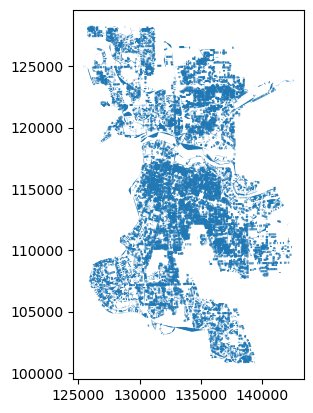

In [103]:
sf_lts['geometry'].convex_hull.plot()

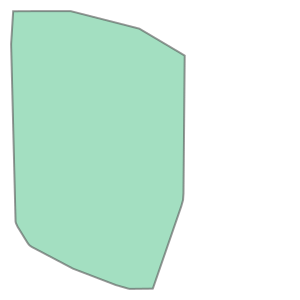

In [104]:
# Get the Convex Hull of the network
convex_hull_area = sf_lts.unary_union.convex_hull
# Show output
convex_hull_area

<AxesSubplot: >

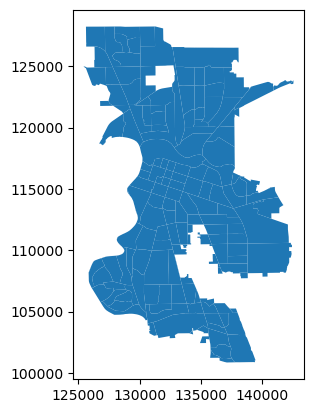

In [105]:
census_track3_sf=gpd.clip(census_track2,convex_hull_area)
census_track3_sf.plot()

In [106]:
convex_hull_area1=convex_hull_area.area
convex_hull_area1

400828911.48496467

In [107]:
# Calculate the number of Intersections
crossroad_nodes = [node for node in sf_lts_g1.nodes() if len(sf_lts_g1.edges(node)) > 2]

In [108]:
def get_number_of_elements(list):
    count = 0
    for element in list:
        count += 1
    return count

#print("Number of elements in the list: ", get_number_of_elements(list_c))

In [109]:
# Number of intersections where edge>2
NI=get_number_of_elements(crossroad_nodes)
NI

11894

# Bicycle  Network Connectivity

<AxesSubplot: >

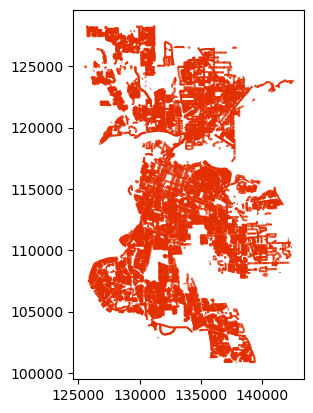

In [110]:
# Get the motorway network and bike network based on functional class of the roads
#sf_motor_network=sf_lts[sf_lts['BIKE_LANE_'].isna()]
sf_motor_network=sf_lts.loc[sf_lts['FT_BIKE_IN']=='0']
# Plot the motor Network
sf_motor_network.plot(color='#e32e00')

<AxesSubplot: >

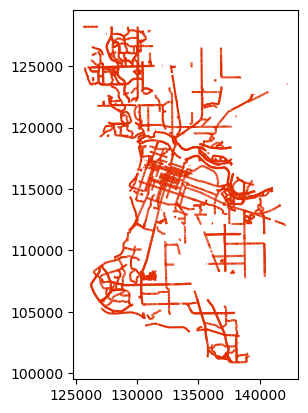

In [111]:
# Plot the Bike Network
sf_bike_network=sf_lts.loc[sf_lts['FT_BIKE_IN']!='0']
sf_bike_network.plot(color='#e32e00')

In [112]:
input_census_tract=census_track3_sf.reset_index()
input_census_tract.shape

(172, 17)

In [113]:
al_connectivity=node_level_connectivity_score (sf_motor_network,sf_bike_network)
al_connectivity.head()

,total_motor_path,nodeID_x,geometry,total_bike_path,nodeID_y,CS
0,1.101090e+04,0.0,POINT (137101.682 100894.425),0.000000e+00,0.0,0.000000
1,1.443221e+04,1.0,POINT (137102.030 100855.414),0.000000e+00,0.0,0.000000
2,1.442951e+04,2.0,POINT (136926.763 100966.764),0.000000e+00,0.0,0.000000
3,1.205559e+06,3.0,POINT (136783.849 101304.361),6.356928e+06,2.0,5.273013
4,1.166451e+06,4.0,POINT (136808.581 101365.697),0.000000e+00,0.0,0.000000


In [114]:
# overall Area Connectivity
BMN_Area_CS=al_connectivity['total_bike_path'].sum()/al_connectivity['total_motor_path'].sum()
BMN_Area_CS

0.2271081494346344

In [115]:
al_connectivity['CS'].median()

0.0

In [116]:
# Save the Alamenda County node level Connectivity
crs = {'init': 'epsg:7131'}
gdf_al = gpd.GeoDataFrame(al_connectivity, crs=crs, geometry = 'geometry')
gdf_al.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Scramento_BMN_node_level_connectivity.shp")

In [117]:
# save the results by Census Tract
CS_median=census_node_level_connectivity_score (al_connectivity,input_census_tract)
CS_median.head()

,GISJOIN,Meadian CS,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0600670000100,0.0,9668,06,067,000100,06067000100,1,Census Tract 1,G5020,S,2030976.0,188167.0,+38.5777705,-121.4326320,8207.326942,2.219143e+06,"POLYGON ((137358.704 115358.672, 137271.501 11..."
1,G0600670000200,0.0,9669,06,067,000200,06067000200,2,Census Tract 2,G5020,S,1511259.0,0.0,+38.5740594,-121.4407580,5167.998505,1.511259e+06,"POLYGON ((136702.979 115207.937, 136675.417 11..."
2,G0600670000300,0.0,9670,06,067,000300,06067000300,3,Census Tract 3,G5020,S,1428326.0,2502.0,+38.5773838,-121.4547432,5004.397801,1.430832e+06,"POLYGON ((135259.479 116978.586, 135294.376 11..."
3,G0600670000400,0.0,9671,06,067,000400,06067000400,4,Census Tract 4,G5020,S,972221.0,0.0,+38.5800861,-121.4693720,4023.597268,9.722200e+05,"POLYGON ((134135.716 116793.992, 134149.999 11..."
4,G0600670000501,0.0,9672,06,067,000501,06067000501,5.01,Census Tract 5.01,G5020,S,395417.0,0.0,+38.5843213,-121.4856339,2570.906577,3.954142e+05,"POLYGON ((132331.893 117154.266, 132311.800 11..."


In [118]:
# Import the node Connectivity
crs = {'init': 'epsg:7131'}
CS_median1 = gpd.GeoDataFrame(CS_median, crs=crs, geometry = 'geometry')
CS_median1.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Sacramento_Census_level_Median_BMN_CS.shp")

# Assign the Grade of the Connectivity for Bike Network-micro connectivity

In [119]:
CS_median['cs_ranking']=CS_median.apply(lambda row:count_census_block(row['Meadian CS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
CS_median.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected     17
fairly connected           3
poorly connected         140
Name: GISJOIN, dtype: int64

# Assign the Grade of the Connectivity for Bike Network-macro connectivity

In [120]:
# Join the nodel level shortest path results with census tract
AC=gpd.sjoin(al_connectivity,input_census_tract)
# aggregrate total bike path by census tract
AC1=pd.DataFrame({'total_bike_path':AC.groupby(['GISJOIN'])['total_bike_path'].sum()}).reset_index()
# aggregrate total motor path by census tract
AC2=pd.DataFrame({'total_motor_path':AC.groupby(['GISJOIN'])['total_motor_path'].sum()}).reset_index()
# join total bike and motor path processing data by census tract GISJOIN id
ACS=pd.merge(AC1, AC2, on=['GISJOIN'], how='inner')
# calculate area connectivity by each census tract
ACS['ACS']=ACS['total_bike_path']/ACS['total_motor_path']
# assigm the grade of the census tract
ACS['cs_ranking']=ACS.apply(lambda row:count_census_block(row['ACS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
ACS.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected    68
fairly connected          9
poorly connected         75
well connected            8
Name: GISJOIN, dtype: int64

# Calculate Low Stress Network Connectivity

<AxesSubplot: >

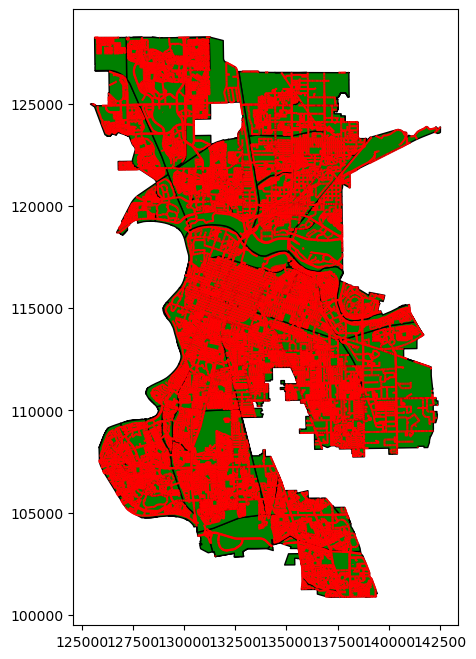

In [121]:
fig, ax = plt.subplots(figsize = (8,8)) 
census_track3_sf.plot(ax=ax,color="green",edgecolor='k')
sf_lts.geometry.plot(color="red",edgecolor='k',ax=ax)

In [122]:
# Split the network as low network to get the connectivity 
sf_motor_network_op2=sf_motor_network
sf_low_stress_network_op2=sf_lts.loc[sf_lts['FT_SEG_STR']<3]

In [123]:
node_level_MLN_CS= node_level_connectivity_score(sf_motor_network_op2,sf_low_stress_network_op2)
node_level_MLN_CS.head()

,total_motor_path,nodeID_x,geometry,total_bike_path,nodeID_y,CS
0,1.101090e+04,0.0,POINT (137101.682 100894.425),11010.900934,0.0,1.000000
1,1.443221e+04,1.0,POINT (137102.030 100855.414),14432.210996,1.0,1.000000
2,1.442951e+04,2.0,POINT (136926.763 100966.764),14429.508732,2.0,1.000000
3,1.205559e+06,3.0,POINT (136783.849 101304.361),772438.082941,5.0,0.640730
4,1.166451e+06,4.0,POINT (136808.581 101365.697),742595.736161,6.0,0.636629


In [124]:
# overall Area Connectivity
LMN_Area_CS=node_level_MLN_CS['total_bike_path'].sum()/node_level_MLN_CS['total_motor_path'].sum()
LMN_Area_CS

0.09082121974735648

In [125]:
node_level_MLN_CS['CS'].median()

0.19662755947146637

In [126]:
# Import the node Connectivity
crs = {'init': 'epsg:7131'}
sfcs1 = gpd.GeoDataFrame(node_level_MLN_CS, crs=crs, geometry = 'geometry')
sfcs1.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Sacramento_node_level_LMN_CS.shp")

In [127]:
CS_median1=census_node_level_connectivity_score (node_level_MLN_CS,input_census_tract)
CS_median1.head()

,GISJOIN,Meadian CS,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0600670000100,0.677477,9668,06,067,000100,06067000100,1,Census Tract 1,G5020,S,2030976.0,188167.0,+38.5777705,-121.4326320,8207.326942,2.219143e+06,"POLYGON ((137358.704 115358.672, 137271.501 11..."
1,G0600670000200,0.012454,9669,06,067,000200,06067000200,2,Census Tract 2,G5020,S,1511259.0,0.0,+38.5740594,-121.4407580,5167.998505,1.511259e+06,"POLYGON ((136702.979 115207.937, 136675.417 11..."
2,G0600670000300,0.014894,9670,06,067,000300,06067000300,3,Census Tract 3,G5020,S,1428326.0,2502.0,+38.5773838,-121.4547432,5004.397801,1.430832e+06,"POLYGON ((135259.479 116978.586, 135294.376 11..."
3,G0600670000400,0.206265,9671,06,067,000400,06067000400,4,Census Tract 4,G5020,S,972221.0,0.0,+38.5800861,-121.4693720,4023.597268,9.722200e+05,"POLYGON ((134135.716 116793.992, 134149.999 11..."
4,G0600670000501,0.000024,9672,06,067,000501,06067000501,5.01,Census Tract 5.01,G5020,S,395417.0,0.0,+38.5843213,-121.4856339,2570.906577,3.954142e+05,"POLYGON ((132331.893 117154.266, 132311.800 11..."


In [128]:
# Import the node Connectivity
crs = {'init': 'epsg:7131'}
CS_median2 = gpd.GeoDataFrame(CS_median1, crs=crs, geometry = 'geometry')
CS_median2.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Sacramento_census_level_LMN_CS.shp")

# Assign the Grade of the Connectivity for Bike Network-micro connectivity

In [129]:
CS_median1 ['cs_ranking']=CS_median1 .apply(lambda row:count_census_block(row['Meadian CS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
CS_median1.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected    32
fairly connected         11
poorly connected         91
very well connected       7
well connected           16
Name: GISJOIN, dtype: int64

# Assign the Grade of the Connectivity for low stress Network-macro connectivity

In [130]:
# Join the nodel level shortest path results with census tract
AC=gpd.sjoin(node_level_MLN_CS,input_census_tract)
# aggregrate total bike path by census tract
AC1=pd.DataFrame({'total_bike_path':AC.groupby(['GISJOIN'])['total_bike_path'].sum()}).reset_index()
# aggregrate total motor path by census tract
AC2=pd.DataFrame({'total_motor_path':AC.groupby(['GISJOIN'])['total_motor_path'].sum()}).reset_index()
# join total bike and motor path processing data by census tract GISJOIN id
ACS=pd.merge(AC1, AC2, on=['GISJOIN'], how='inner')
# calculate area connectivity by each census tract
ACS['ACS']=ACS['total_bike_path']/ACS['total_motor_path']
# assigm the grade of the census tract
ACS['cs_ranking']=ACS.apply(lambda row:count_census_block(row['ACS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
ACS.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected     23
fairly connected          15
poorly connected         103
very well connected        6
well connected            10
Name: GISJOIN, dtype: int64

# End of coding